In [ ]:
!pip install gdown

In [ ]:
import gdown

# File 1: Download the first dataset
file1_id = "1S0ozp5PYL1lGVeboCl3dS83vErEvjRmm"
file1_output = "emission.csv"
gdown.download(f"https://drive.google.com/uc?id={file1_id}", file1_output, quiet=False)

# File 2: Download the second dataset
file2_id = "1z-M19AmIQShz4WQmwbI7-qpRVyiAUTQ5"
file2_output = "year.csv"
gdown.download(f"https://drive.google.com/uc?id={file2_id}", file2_output, quiet=False)

# File 3: Download the third dataset
file3_id = "1LBUiSMnuIyPzXa7SZj8loXUWax3Fxnmk"
file3_output = "category.csv"
gdown.download(f"https://drive.google.com/uc?id={file3_id}", file3_output, quiet=False)

# File 3: Download the third dataset
file4_id = "1xyOx81w0E58cVKWaFtpjSJRk2djEA1J8"
file4_output = "type.csv"
gdown.download(f"https://drive.google.com/uc?id={file4_id}", file4_output, quiet=False)

# File 5: Download the third dataset
file5_id = "1Nhmvo_RyFGbLnPeeXn3feLwlEZ_iX4x7"
file5_output = "finance.csv"
gdown.download(f"https://drive.google.com/uc?id={file5_id}", file5_output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1S0ozp5PYL1lGVeboCl3dS83vErEvjRmm
To: /content/emission.csv
100%|██████████| 19.6k/19.6k [00:00<00:00, 30.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1z-M19AmIQShz4WQmwbI7-qpRVyiAUTQ5
To: /content/year.csv
100%|██████████| 262/262 [00:00<00:00, 436kB/s]
Downloading...
From: https://drive.google.com/uc?id=1LBUiSMnuIyPzXa7SZj8loXUWax3Fxnmk
To: /content/category.csv
100%|██████████| 89.0/89.0 [00:00<00:00, 224kB/s]
Downloading...
From: https://drive.google.com/uc?id=1xyOx81w0E58cVKWaFtpjSJRk2djEA1J8
To: /content/type.csv
100%|██████████| 72.0/72.0 [00:00<00:00, 194kB/s]
Downloading...
From: https://drive.google.com/uc?id=1Nhmvo_RyFGbLnPeeXn3feLwlEZ_iX4x7
To: /content/finance.csv
100%|██████████| 316/316 [00:00<00:00, 856kB/s]


'finance.csv'

Mean Squared Error: 14487238.54404297
Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


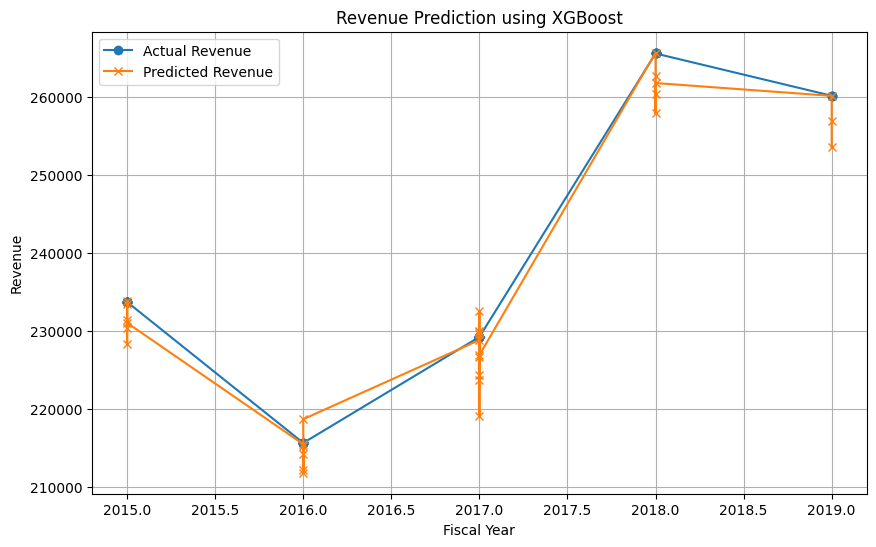

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Load the datasets
emissions_df = pd.read_csv('emission.csv')
category_df = pd.read_csv('category.csv')
year_df = pd.read_csv('year.csv')
type_df = pd.read_csv('type.csv')
financial_df = pd.read_csv('finance.csv')

# Merge datasets
emissions_df = emissions_df.merge(category_df, on='PK_category', how='left')
emissions_df = emissions_df.merge(year_df[['PK_year', 'FiscalYear']], on='PK_year', how='left')
emissions_df = emissions_df.merge(type_df, on='PK_EmissionType', how='left')
emissions_df.drop(columns=['PK_category', 'PK_year', 'PK_EmissionType'], inplace=True)
emissions_df_encoded = pd.get_dummies(emissions_df, columns=['categoryName', 'TypeName'], drop_first=True)
emissions_df_encoded = emissions_df_encoded[emissions_df_encoded['Emissions'] <= 4270]

# Merge financial data
data = emissions_df_encoded.merge(financial_df, on='FiscalYear', how='left')

# Prepare the data for XGBoost
data.set_index('FiscalYear', inplace=True)
data = data[['Revenue', 'Emissions']]  # Select relevant columns

# Create lagged features for time series
for lag in range(1, 4):  # Create 3 lagged features
    data[f'Emissions_lag_{lag}'] = data['Emissions'].shift(lag)

# Create rolling statistics as additional features
data['Revenue_rolling_mean'] = data['Revenue'].rolling(window=3).mean()
data['Revenue_rolling_std'] = data['Revenue'].rolling(window=3).std()
data['Emissions_rolling_mean'] = data['Emissions'].rolling(window=3).mean()

# Drop rows with NaN values created by lagging and rolling statistics
data.dropna(inplace=True)

# Split the data into features and target
X = data.drop(columns='Revenue')
y = data['Revenue']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Initialize the XGBoost model with hyperparameter tuning
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(xgb_model, param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Best Parameters: {grid_search.best_params_}')

# Visualizing the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Revenue', marker='o')
plt.plot(y_test.index, y_pred, label='Predicted Revenue', marker='x')
plt.title('Revenue Prediction using XGBoost')
plt.xlabel('Fiscal Year')
plt.ylabel('Revenue')
plt.legend()
plt.grid()
plt.show()


<ipython-input-8-40cee534e1d5>:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_years['Emissions_rolling_mean'] = future_years['Emissions'].rolling(window=3).mean().fillna(method='bfill')


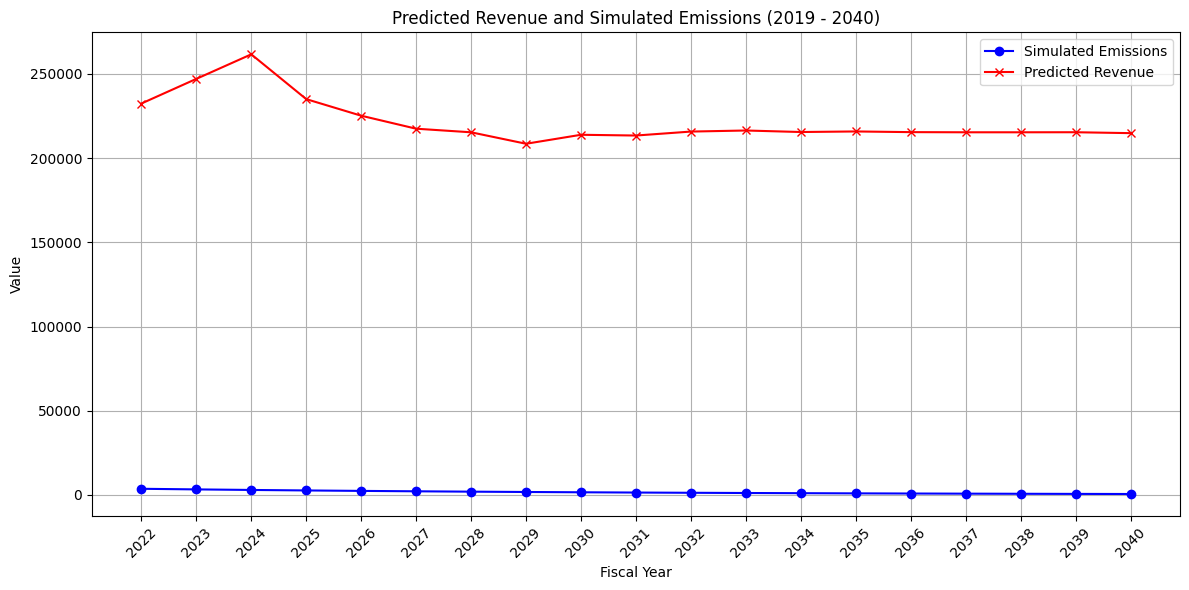

    FiscalYear    Emissions  Predicted_Revenue
3         2022  3645.000000      232428.296875
4         2023  3280.500000      247075.640625
5         2024  2952.450000      261657.796875
6         2025  2657.205000      235048.734375
7         2026  2391.484500      225203.109375
8         2027  2152.336050      217480.734375
9         2028  1937.102445      215350.765625
10        2029  1743.392201      208543.390625
11        2030  1569.052980      213874.140625
12        2031  1412.147682      213428.515625
13        2032  1270.932914      215778.750000
14        2033  1143.839623      216416.500000
15        2034  1029.455660      215514.718750
16        2035   926.510094      215848.218750
17        2036   833.859085      215447.500000
18        2037   750.473176      215355.781250
19        2038   675.425859      215355.781250
20        2039   607.883273      215384.968750
21        2040   547.094946      214847.718750


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set the last known emissions value for the year 2019
base_emissions = 5000
# Prepare the DataFrame for predictions (years 2019 to 2040)
future_years = pd.DataFrame({'FiscalYear': range(2019, 2041)})

# Simulate future emissions with a 10% decrease each year
future_emissions = []

# Decrease rate for emissions (10% decrease each year)
decrease_rate = 0.10
for year in range(len(future_years)):
    if year == 0:
        future_emissions.append(base_emissions)  # Start with emissions from 2019
    else:
        future_emissions.append(future_emissions[-1] * (1 - decrease_rate))

future_years['Emissions'] = future_emissions

# Create lagged features for the future years
for lag in range(1, 4):  # Create 3 lagged features
    future_years[f'Emissions_lag_{lag}'] = future_years['Emissions'].shift(lag)

# Create dynamic rolling statistics based on simulated emissions
future_years['Revenue_rolling_mean'] = np.mean(future_years['Emissions'])  # Using average emissions for this example
future_years['Revenue_rolling_std'] = np.std(future_years['Emissions'])  # Using std of emissions
future_years['Emissions_rolling_mean'] = future_years['Emissions'].rolling(window=3).mean().fillna(method='bfill')

# Drop rows with NaN values created by lagging
future_years.dropna(inplace=True)

# Scale the features
future_X = future_years.drop(columns='FiscalYear')
future_X_scaled = scaler.transform(future_X)

# Make predictions for future years
future_predictions = best_model.predict(future_X_scaled)

# Add predictions to the future_years DataFrame
future_years['Predicted_Revenue'] = future_predictions

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(future_years['FiscalYear'], future_years['Emissions'], label='Simulated Emissions', marker='o', color='b')
plt.plot(future_years['FiscalYear'], future_years['Predicted_Revenue'], label='Predicted Revenue', marker='x', color='r')

plt.title('Predicted Revenue and Simulated Emissions (2019 - 2040)')
plt.xlabel('Fiscal Year')
plt.ylabel('Value')
plt.xticks(future_years['FiscalYear'], rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Display predictions for years 2019 to 2040
print(future_years[['FiscalYear', 'Emissions', 'Predicted_Revenue']])
